In this notebook we compare the translational mobility coefficients for three spheres, sedimenting parallel or perpendicular to their line of centers. We compare

 - PyStokes (superposition approximation)
 - FTS Stokesian dynamics
 - linear solver: including all long-ranged traction modes
 
Exact solution?

One time-step is enough, so no simulation needed. We compare the mobilities, using the linear solver as a base line. Expect Pystokes to do worse than for 2 particles, given it uses the superposition approximation.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt

import pystokes
from linearSolveFTS import linearSolve_direct as FTS
from linearSolve import linearSolve_direct as linearSolve
from linearSolveKrylov import linearSolve_krylov as krylov

In [2]:
PI = 3.14159265359

# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 3, 0.1

## passive particle
D0  = 0.      
S0  = 0.

## normalising factor: one-particle mobility
mu0 = 1./(6*PI*eta*b)

The results are compared at the nine fixed ratios $r/b$, where $r$ is the centre-to-centre distance: $2.0,\, 2.0049,\, 2.0907,\, 2.2553,\, 2.6749,\, 3.0862,\, 4.0,\, 6.0,\, 8.0$

In [3]:
rb = np.array([2.0, 2.0049, 2.0907, 2.2553, 2.6749, 3.0862, 4.0, 6.0, 8.0])

## 1) Particles in line on x-axis

### Pystokes

In [4]:
pstk = pystokes.unbounded.Rbm(b, Np, eta)
## define distances that iterate through rb and forces parallel and perpendicular to these distances 

line_pstk_muPara = np.zeros(rb.shape[0])
line_pstk_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_
    r[1] =  0.
    r[2] =  rb_
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    line_pstk_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[0] is vx of particle 1
    print(v)
    k += 1
    
print("\n\n\n")
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_
    r[1] =  0.
    r[2] =  rb_
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    line_pstk_muPerp[k] = v[0+2*Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[2*Np=6] is vz of particle one
    print(v)
    k += 1

[1.05274363 1.19366207 1.05274363 0.         0.         0.
 0.         0.         0.        ]
[1.05183063 1.19268726 1.05183063 0.         0.         0.
 0.         0.         0.        ]
[1.03614595 1.17566267 1.03614595 0.         0.         0.
 0.         0.         0.        ]
[1.00775807 1.14371498 1.00775807 0.         0.         0.
 0.         0.         0.        ]
[0.94557819 1.07007264 0.94557819 0.         0.         0.
 0.         0.         0.        ]
[0.89698664 1.01011941 0.89698664 0.         0.         0.
 0.         0.         0.        ]
[0.81960651 0.91182519 0.81960651 0.         0.         0.
 0.         0.         0.        ]
[0.72669705 0.79086253 0.72669705 0.         0.         0.
 0.         0.         0.        ]
[0.67855855 0.72738783 0.67855855 0.         0.         0.
 0.         0.         0.        ]




[0.         0.         0.         0.         0.         0.
 0.86623394 0.99471839 0.86623394]
[0.         0.         0.         0.         0.         

velocities of the three particles are not the same, so it is ambiguous which mobility to compute. This configuration is not fully symmetric. Instead, use three particles in a triangle, with a force perpendicular to the plane spanned by the centers of the particles.

In [5]:
line_pstk_muPara

array([1.984375  , 1.98265404, 1.9530891 , 1.89957922, 1.7823729 ,
       1.69077998, 1.54492187, 1.36979167, 1.27905273])

In [6]:
line_pstk_muPerp

array([1.6328125 , 1.63092347, 1.59965002, 1.54786037, 1.44996649,
       1.38366192, 1.29003906, 1.19010417, 1.14172363])

___________

### FTS Stokesian dynamics

In [7]:
lsFTS = FTS(b, Np, eta) 

line_FTS_muPara = np.zeros(rb.shape[0])
line_FTS_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_
    r[1] =  0.
    r[2] =  rb_
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    lsFTS.RBM(v, o, r, F, T, S)
        
    line_FTS_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_
    r[1] =  0.
    r[2] =  rb_
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    lsFTS.RBM(v, o, r, F, T, S)
        
    line_FTS_muPerp[k] = v[0+2*Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [8]:
line_FTS_muPara

array([1.95001484, 1.94851299, 1.92259593, 1.87507835, 1.76814124,
       1.68208402, 1.54154512, 1.36907636, 1.27882107])

In [9]:
line_FTS_muPerp

array([1.63239087, 1.63051005, 1.59935483, 1.54769979, 1.44992565,
       1.38364894, 1.29003744, 1.1901041 , 1.14172363])

______________

## Linear solver

In [10]:
ls = linearSolve(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

line_ls_muPara = np.zeros(rb.shape[0])
line_ls_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)
D = np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_
    r[1] =  0.
    r[2] =  rb_
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    ls.RBM(v, o, r, F, T, S, D)
        
    line_ls_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_
    r[1] =  0.
    r[2] =  rb_
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ls.RBM(v, o, r, F, T, S, D)
        
    line_ls_muPerp[k] = v[0+2*Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [11]:
line_ls_muPara

array([1.9412018 , 1.93971966, 1.91413851, 1.86733569, 1.76277563,
       1.67877859, 1.5404988 , 1.36895499, 1.27879759])

In [12]:
line_ls_muPerp

array([1.61905484, 1.61737158, 1.58917077, 1.54124264, 1.44756066,
       1.38261746, 1.28980804, 1.19008277, 1.14171974])

___________

## 2) Particles in triangle with base on x-axis

Only truly symmetric configuration of three particles.

### Pystokes

In [13]:
pstk = pystokes.unbounded.Rbm(b, Np, eta)

triangle_pstk_muPerp = np.zeros(rb.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
 
## perpendicular
k=0
for rb_ in rb:
    # triangle
    # x components
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rb_/6.
    r[1+2*Np] =  np.sqrt(3)*rb_/6.
    r[2+2*Np] = -np.sqrt(3)*rb_/3.
    
    for i in range(Np):
        #force perpendicular to triangle - along y axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    triangle_pstk_muPerp[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    k += 1

In [14]:
triangle_pstk_muPerp

array([1.875     , 1.87225272, 1.82689014, 1.752274  , 1.61301755,
       1.5200541 , 1.390625  , 1.25462963, 1.18945312])

___________

### FTS Stokesian dynamics

In [15]:
lsFTS = FTS(b, Np, eta) 

triangle_FTS_muPerp = np.zeros(rb.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)

## perpendicular
k=0
for rb_ in rb:
    # triangle
    # x components
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rb_/6.
    r[1+2*Np] =  np.sqrt(3)*rb_/6.
    r[2+2*Np] = -np.sqrt(3)*rb_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    lsFTS.RBM(v, o, r, F, T, S)
        
    triangle_FTS_muPerp[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [16]:
triangle_FTS_muPerp

array([1.85564516, 1.85325827, 1.81315774, 1.74470879, 1.61108875,
       1.51944619, 1.39055004, 1.25462675, 1.18945284])

______________

## Linear solver

In [17]:
ls = linearSolve(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

triangle_ls_muPerp = np.zeros(rb.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)
D = np.zeros(3*Np)

## perpendicular
k=0
for rb_ in rb:
    # triangle
    # x components
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rb_/6.
    r[1+2*Np] =  np.sqrt(3)*rb_/6.
    r[2+2*Np] = -np.sqrt(3)*rb_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ls.RBM(v, o, r, F, T, S, D)
        
    triangle_ls_muPerp[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    print(v)
    k += 1

[0.         0.         0.         0.98121747 0.98121747 0.98090887
 0.         0.         0.        ]
[0.         0.         0.         0.98001087 0.98001087 0.97970482
 0.         0.         0.        ]
[0.         0.         0.         0.95959841 0.95959841 0.95933401
 0.         0.         0.        ]
[0.         0.         0.         0.92425841 0.92425841 0.92406289
 0.         0.         0.        ]
[0.         0.         0.         0.85424482 0.85424482 0.8541622
 0.         0.         0.        ]
[0.         0.         0.         0.80587713 0.80587713 0.80584148
 0.         0.         0.        ]
[0.         0.         0.         0.73765549 0.73765549 0.73764848
 0.         0.         0.        ]
[0.         0.         0.         0.66559445 0.66559445 0.66559392
 0.         0.         0.        ]
[0.         0.         0.         0.63102324 0.63102324 0.63102315
 0.         0.         0.        ]


There is a numerical error introduced by the square roots in the distances leading to a differing velocity for the third particle! This becomes more prominent the closer the spheres are, since $\Delta r/r$ increases, where $\Delta r$ is the constant numerical error.

In [18]:
## changes in the distances between particles 1 and 2 and between 1 and 3
np.linalg.norm(r[::Np]-r[1::Np]) - np.linalg.norm(r[::Np]-r[2::Np])

8.881784197001252e-16

In [19]:
triangle_ls_muPerp

array([1.84955135, 1.84727696, 1.80880038, 1.74218607, 1.61021355,
       1.51904261, 1.39044784, 1.25461598, 1.18945079])

In [20]:
rb

array([2.    , 2.0049, 2.0907, 2.2553, 2.6749, 3.0862, 4.    , 6.    ,
       8.    ])

_____

## Corrected long-ranged solver

In [21]:
ky = krylov(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

triangle_ky_muPerp = np.zeros(rb.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(6*Np)
D = np.zeros(3*Np)

## perpendicular
k=0
for rb_ in rb:
    # triangle
    # x components
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rb_/6.
    r[1+2*Np] =  np.sqrt(3)*rb_/6.
    r[2+2*Np] = -np.sqrt(3)*rb_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ky.RBM(v, o, r, F, T, S, D)
        
    triangle_ky_muPerp[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    print(v)
    k += 1

[0.         0.         0.         0.96706272 0.96706272 0.96686117
 0.         0.         0.        ]
[0.         0.         0.         0.96610018 0.96610018 0.9658944
 0.         0.         0.        ]
[0.         0.         0.         0.94938459 0.94938459 0.9491288
 0.         0.         0.        ]
[0.         0.         0.         0.91859321 0.91859321 0.91833021
 0.         0.         0.        ]
[0.         0.         0.         0.85272907 0.85272907 0.85258276
 0.         0.         0.        ]
[0.         0.         0.         0.80533454 0.80533454 0.80526432
 0.         0.         0.        ]
[0.         0.         0.         0.73755792 0.73755792 0.73754205
 0.         0.         0.        ]
[0.         0.         0.         0.66558653 0.66558653 0.66558511
 0.         0.         0.        ]
[0.         0.         0.         0.63102185 0.63102185 0.6310216
 0.         0.         0.        ]


________________

## Plotting

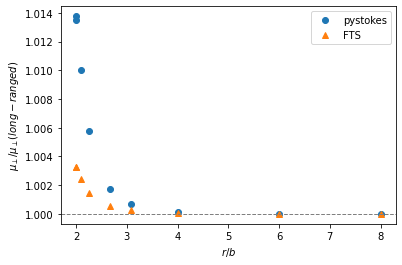

In [22]:
plt.plot(rb, triangle_pstk_muPerp/triangle_ls_muPerp, label='pystokes', marker='o', linestyle="None")
plt.plot(rb, triangle_FTS_muPerp/triangle_ls_muPerp, label='FTS', marker='^', linestyle="None")
#plt.plot(rb, triangle_ls_muPerp, label='full', marker='x', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu_\perp/\mu_\perp(long-ranged)$')
plt.legend()
plt.show()

Could include Ladd's results for 3 particles in a line, he compares 3-body contributions and 2-body superposition contribution. Probably less interesting than previous exact results for 2 spheres. 

_________

### Other solutions

**Helen J Wilson (2013)** (drag & mobility), **Tran-Cong and Phan-Thien (1989)** (drag, Fig 10, rotating & non-rotating), **Kim (1987)** (drag, no rotation), **Lasso and Weidemann (1986)** (experimental, non-rotating)

Comparison to **Helen J Wilson (2013)** of three (freely rotating) spheres in a triangle, method based on Lamb's solution and method of reflections (MR) - convergence, so in principle exact. Good benchmark

In [23]:
## rHW = separation for Helen Wilson, muTT_HW and muRT_HW vs muTT_ls and muRT_ls (linear solver). No need to explicitly mention 'Perp', since this is the only relevant config

In [24]:
rHW = np.array([2.01, 2.05, 2.10, 2.15, 2.20, 2.25, 2.30, 2.40, 2.50, 2.60, 2.70, 2.80, 2.90, 3.00])

muTT_HW = np.array([1.79223228, 1.79070892, 1.77826951, 1.76311004, 1.74703222, 1.73072508, 1.71452988, 1.68314045, 1.65356957, 1.62599574, 1.60039150,
                    1.57664602, 1.55461831, 1.53416156])
muRT_HW = np.array([0.159607490, 0.195478184, 0.209731929, 0.214756269, 0.215412007, 0.213577673, 0.210224103, 0.201041187, 0.190411103, 0.179481457, 0.168801210,
                    0.158630515, 0.149081378, 0.140187608])

In [25]:
## Force = 6*pi*eta*b in HW

### Pystokes

In [26]:
pstk = pystokes.unbounded.Rbm(b, Np, eta)

muTT_pstk = np.zeros(rHW.shape[0])
muRT_pstk = np.zeros(rHW.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
 
## perpendicular
k=0
for rHW_ in rHW:
    # triangle
    # x components
    r[0] = -rHW_/2.
    r[1] =  rHW_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rHW_/6.
    r[1+2*Np] =  np.sqrt(3)*rHW_/6.
    r[2+2*Np] = -np.sqrt(3)*rHW_/3.
    
    for i in range(Np):
        #force perpendicular to triangle - along y axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    muTT_pstk[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    muRT_pstk[k] = np.abs(o[2]/mu0) ## due to symmetry, use angular velocity of particle 3, which is purely in x direction
    k += 1

In [27]:
muTT_pstk

array([1.86941225, 1.84778224, 1.82226541, 1.79829449, 1.77573253,
       1.75445816, 1.73436344, 1.69733796, 1.664     , 1.63381884,
       1.60636082, 1.58126822, 1.55824347, 1.53703704])

In [28]:
muRT_pstk

array([0.32153613, 0.30911079, 0.29456646, 0.28102501, 0.2683963 ,
       0.25660012, 0.24556486, 0.22552745, 0.2078461 , 0.1921654 ,
       0.17819453, 0.16569364, 0.15446351, 0.14433757])

___________

### FTS Stokesian dynamics

In [29]:
lsFTS = FTS(b, Np, eta) 

muTT_FTS = np.zeros(rHW.shape[0])
muRT_FTS = np.zeros(rHW.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)

## perpendicular
k=0
for rHW_ in rHW:
    # triangle
    # x components
    r[0] = -rHW_/2.
    r[1] =  rHW_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rHW_/6.
    r[1+2*Np] =  np.sqrt(3)*rHW_/6.
    r[2+2*Np] = -np.sqrt(3)*rHW_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    lsFTS.RBM(v, o, r, F, T, S)
        
    muTT_FTS[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    muRT_FTS[k] = np.abs(o[2]/mu0) ## due to symmetry, use angular velocity of particle 3, which is purely in x direction
    k += 1

In [30]:
muTT_FTS

array([1.85078521, 1.83178357, 1.80900018, 1.78726082, 1.76652549,
       1.74675051, 1.7278902 , 1.69272838, 1.66067667, 1.63139428,
       1.60457191, 1.57993415, 1.55723853, 1.53627281])

In [31]:
muRT_FTS

array([0.29113834, 0.28248273, 0.27194941, 0.26176483, 0.25195089,
       0.24252   , 0.23347694, 0.21654542, 0.20110058, 0.1870473 ,
       0.174273  , 0.16266087, 0.15209737, 0.14247615])

______________

## Linear solver

In [32]:
ls = linearSolve(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

muTT_ls = np.zeros(rHW.shape[0])
muRT_ls = np.zeros(rHW.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)
D = np.zeros(3*Np)

## perpendicular
k=0
for rHW_ in rHW:
    # triangle
    # x components
    r[0] = -rHW_/2.
    r[1] =  rHW_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rHW_/6.
    r[1+2*Np] =  np.sqrt(3)*rHW_/6.
    r[2+2*Np] = -np.sqrt(3)*rHW_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ls.RBM(v, o, r, F, T, S, D)
        
    muTT_ls[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    muRT_ls[k] = np.abs(o[2]/mu0) ## due to symmetry, use angular velocity of particle 3, which is purely in x direction
    k += 1

In [33]:
muTT_ls

array([1.84491847, 1.82673183, 1.80478478, 1.78371715, 1.76352306,
       1.74418641, 1.72568338, 1.69105776, 1.6593792 , 1.63036507,
       1.60374142, 1.5792548 , 1.55667667, 1.53580394])

In [34]:
muRT_ls

array([0.2823506 , 0.27504935, 0.26592539, 0.25688362, 0.24799307,
       0.23930679, 0.23086377, 0.21480615, 0.19993189, 0.1862541 ,
       0.17372929, 0.16228465, 0.15183474, 0.14229134])

__________

## Corrected long-ranged solver

In [35]:
ky = krylov(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

muTT_ky = np.zeros(rHW.shape[0])
muRT_ky = np.zeros(rHW.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(6*Np)
D = np.zeros(3*Np)

## perpendicular
k=0
for rHW_ in rHW:
    # triangle
    # x components
    r[0] = -rHW_/2.
    r[1] =  rHW_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rHW_/6.
    r[1+2*Np] =  np.sqrt(3)*rHW_/6.
    r[2+2*Np] = -np.sqrt(3)*rHW_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ky.RBM(v, o, r, F, T, S, D)
        
    muTT_ky[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    muRT_ky[k] = np.abs(o[2]/mu0) ## due to symmetry, use angular velocity of particle 3, which is purely in x direction
    k += 1

In [36]:
muTT_ky

array([1.81916894, 1.80442437, 1.78617052, 1.76818421, 1.75054138,
       1.73330787, 1.71653582, 1.68451041, 1.65460993, 1.62682929,
       1.60107587, 1.57721396, 1.55509193, 1.53455756])

In [37]:
muRT_ky

array([0.23512666, 0.23349581, 0.23067644, 0.22707658, 0.22282328,
       0.2180548 , 0.2129031 , 0.20190729, 0.19057515, 0.1793875 ,
       0.16862926, 0.15845172, 0.1489213 , 0.14005301])

________

### Plotting versus Helen Wilson

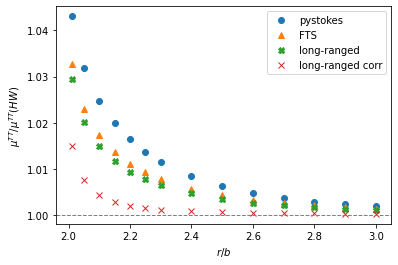

In [38]:
plt.plot(rHW, muTT_pstk/muTT_HW, label='pystokes', marker='o', linestyle="None")
plt.plot(rHW, muTT_FTS/muTT_HW, label='FTS', marker='^', linestyle="None")
plt.plot(rHW, muTT_ls/muTT_HW, label='long-ranged', marker='X', linestyle="None")
plt.plot(rHW, muTT_ky/muTT_HW, label='long-ranged corr', marker='x', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu^{TT}/\mu^{TT}(HW)$')
plt.legend()
plt.show()

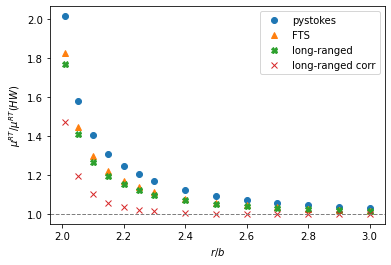

In [39]:
plt.plot(rHW, muRT_pstk/muRT_HW, label='pystokes', marker='o', linestyle="None")
plt.plot(rHW, muRT_FTS/muRT_HW, label='FTS', marker='^', linestyle="None")
plt.plot(rHW, muRT_ls/muRT_HW, label='long-ranged', marker='X', linestyle="None")
plt.plot(rHW, muRT_ky/muRT_HW, label='long-ranged corr', marker='x', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu^{RT}/\mu^{RT}(HW)$')
plt.legend()
plt.show()

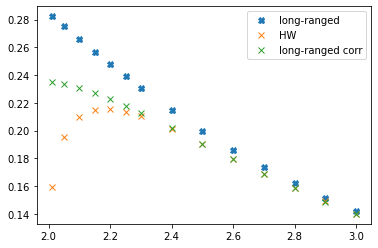

In [40]:
plt.plot(rHW, muRT_ls, label='long-ranged', marker='X', linestyle="None")
plt.plot(rHW, muRT_HW, label='HW', marker='x', linestyle="None")
plt.plot(rHW, muRT_ky, label='long-ranged corr', marker='x', linestyle="None")
plt.legend()
plt.show()

That's a terrible result! Why, physically, does mu_RT grow and then fall again for increasing radius? Probably because the three particles have to stop rotating when actually touching (no-slip boundary condition), and in order for the mobilityRT to be continous around touching, it has to decrease. 

Result might be so bad, because 3-body interactions are $\sim 1/r^4$, so would have to include higher order traction moments. Good to find limitations of our theory

-----------

Roughly compare with drag result by **Tran-Cong and Phan-Thien (1989)**, Fig 10, for freely rotating spheres and assume $\gamma^{TT} \approx 1/\mu^{TT}$

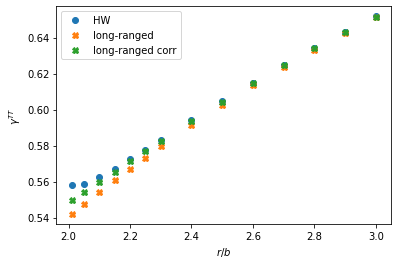

In [41]:
plt.plot(rHW, 1/muTT_HW, label='HW', marker='o', linestyle="None")
plt.plot(rHW, 1/muTT_ls, label='long-ranged', marker='X', linestyle="None")
plt.plot(rHW, 1/muTT_ky, label='long-ranged corr', marker='X', linestyle="None")
plt.xlabel('$r/b$')
plt.ylabel('$\gamma^{TT}$')
plt.legend()
plt.show()

Visually, HW matches form of curve found in the paper much better. Should we include lubrication forces after all? Need resistance formulation, for which an exact two-body lubrication formula is known? 

In three-body problems it is likely that order 4 moments play a significant role (from method of reflections). Ratio of 1/r^4 to 1/r^3 is simply 1/r, so 1/r^4 becomes larger than 1/r^3 at r=1. Which distance is important here, centre to centre (mathematically) or surface to surface (physically)?

I think it is actually centre to centre, so any relevant (physical) r>=2, so that the particles do not overlap. The significance of moments will be different for the translational and the rotational mobilities. 